# 1- Class Activation Map with convolutions

In this firt part, we will code class activation map as described in the paper [Learning Deep Features for Discriminative Localization](http://cnnlocalization.csail.mit.edu/)

There is a GitHub repo associated with the paper:
https://github.com/zhoubolei/CAM

And even a demo in PyTorch:
https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py

The code below is adapted from this demo but we will not use hooks only convolutions...

In [1]:
import io
import requests
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import cv2
import pdb
from matplotlib.pyplot import imshow


# input image
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

As in the demo, we will use the Resnet18 architecture. In order to get CAM, we need to transform this network in a fully convolutional network: at all layers, we need to deal with images, i.e. with a shape $\text{Number of channels} \times W\times H$ . In particular, we are interested in the last images as shown here:
![](https://camo.githubusercontent.com/fb9a2d0813e5d530f49fa074c378cf83959346f7/687474703a2f2f636e6e6c6f63616c697a6174696f6e2e637361696c2e6d69742e6564752f6672616d65776f726b2e6a7067)

As we deal with a Resnet18 architecture, the image obtained before applying the `AdaptiveAvgPool2d` has size $512\times 7 \times 7$ if the input has size $3\times 224\times 224 $:
![resnet_Archi](https://pytorch.org/assets/images/resnet.png)

A- The first thing, you will need to do is 'removing' the last layers of the resnet18 model which are called `(avgpool)` and `(fc)`. Check that for an original image of size $3\times 224\times 224 $, you obtain an image of size $512\times 7\times 7$.

B- Then you need to retrieve the weights (and bias) of the `fc` layer, i.e. a matrix of size $1000\times 512$ transforming a vector of size 512 into a vector of size 1000 to make the prediction. Then you need to use these weights and bias to apply it pixelwise in order to transform your $512\times 7\times 7$ image into a $1000\times 7\times 7$ output (Hint: use a convolution). You can interpret this output as follows: `output[i,j,k]` is the logit for 'pixel' `[j,k]` for being of class `i`.

C- From this $1000\times 7\times 7$ output, check that you can retrieve the original output given by the `resnet18` by using an `AdaptiveAvgPool2d`. Can you understand why this is true?

D- In addition, you can construct the Class Activation Map. Draw the activation map for the class mountain bike, for the class lakeside.

## Validation:
1. make sure that when running your notebook, you display both CAM for the class mountain bike and for the class lakeside.
2. for question B above, what convolution did you use? Your answer, i.e. the name of the Pytorch layer with the correct parameters (in_channel,kernel...) here:

<span style="color:red">**Answer:**</span>
``` 
# conv layer
convolution_layer = nn.Conv2d(in_channels=512,
                              out_channels=1000,
                              kernel_size=(1, 1))

# initializing weight and bias
convolution_layer.weight.data = net.fc.weight.data.unsqueeze(2).unsqueeze(3)
convolution_layer.bias.data = net.fc.bias.data
```
3. your short explanation of why your network gives the same predicition as the original `resnet18`:

<span style="color:red">**Answer:**</span>     
The new network, based on the `Resnet18` architecture, gives the same prediction as the original `Resnet18` model because it uses the same linear transformation performed by the fc layer, as a 1x1 `Conv2d` layer with the same weights and biases. Additionally, the use of `AdaptiveAvgPool2d` after the `Conv2d` layer outputs the spatial average of the feature map of each unit at the last convolutional layer, as is done in the original `Resnet18` model. As a result, we perform the same calculations as in the original model, and thus the same predictions.
4. Is your network working on an image which is not of size $224\times 224$, i.e. without resizing? and what about `resnet18`? Explain why?

<span style="color:red">**Answer:**</span>    
  We can feed images which are not of size  $224 \times 224$ without resizing them to both networks. However, since the new network and the original `Resnet18` model are designed to work with input images of size $224 \times 224$, predictions we will produce won't be accurate as if we feed it resized image.      
  Reasons why we can feed images of different sizes to the network:
  - The new network is fully convolutional and as a result, it doesn't have any limitations on the input size.
  - The `resnet18` model uses only convolutional layers at the beginning and before using the fully connected layer, it uses the average pooling layer which leads to the output dimensionality being independent of the spatial size of the feature maps.

In [2]:
net = models.resnet18(pretrained=True)

c:\Users\Abdessalam Ed-dib\Desktop\Deep Learning Course\dldiy\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Abdessalam Ed-dib\Desktop\Deep Learning Course\dldiy\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
x = torch.randn(5, 3, 224, 224)
y = net(x)
y.shape

torch.Size([5, 1000])

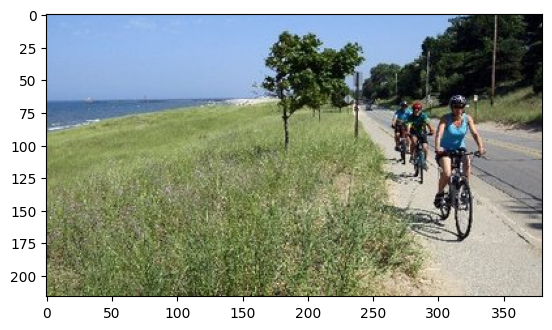

In [5]:
n_mean = [0.485, 0.456, 0.406]
n_std = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(
   mean=n_mean,
   std=n_std
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

# Display the image we will use.
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
imshow(img_pil);

In [6]:
img_tensor = preprocess(img_pil)
net = net.eval()
logit = net(img_tensor.unsqueeze(0))

In [7]:
logit.shape

torch.Size([1, 1000])

In [8]:
img_tensor.shape

torch.Size([3, 224, 224])

In [9]:
# download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}


def print_preds(logit):
    # print the predicitions with their 'probabilities' from the logit
    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

In [10]:
idx = print_preds(logit)

0.416 -> ['n03792782', 'mountain_bike']
0.144 -> ['n09193705', 'alp']
0.113 -> ['n02835271', 'bicycle-built-for-two']
0.106 -> ['n04509417', 'unicycle']
0.055 -> ['n09332890', 'lakeside']


In [11]:
def returnCAM(feature_conv, idx):
    # input: tensor feature_conv of dim 1000*W*H and idx between 0 and 999
    # output: image W*H with entries rescaled between 0 and 255 for the display
    cam = feature_conv[idx].detach().numpy()
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    return cam_img

In [12]:
#some utilities
def pil_2_np(img_pil):
    # transform a PIL image in a numpy array
    return np.asarray(img_pil)

def display_np(img_np):
    imshow(Image.fromarray(np.uint8(img_np)))
    
def plot_CAM(img_np, CAM):
    height, width, _ = img_np.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAM,(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img_np * 0.5
    display_np(result)

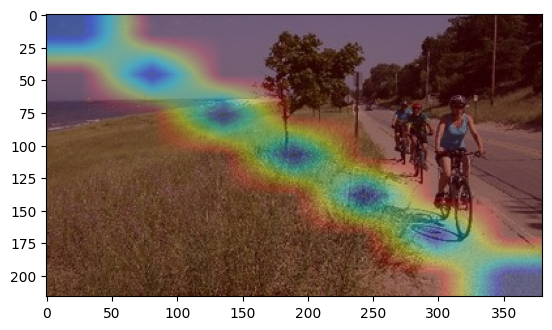

In [13]:
# here is a fake example to see how things work
img_np = pil_2_np(img_pil)
diag_CAM = returnCAM(torch.eye(7).unsqueeze(0),0)
plot_CAM(img_np,diag_CAM)

In [14]:
# your code here for your new network
net_conv = nn.Sequential(*list(net.children())[:-2])
# do not forget:
net_conv = net_conv.eval()

In [15]:
# to test things are right
x = torch.randn(5, 3, 224, 224)
y = net_conv(x)
y.shape

torch.Size([5, 512, 7, 7])

In [16]:
# conv layer
convolution_layer = nn.Conv2d(in_channels=512,
                              out_channels=1000,
                              kernel_size=(1, 1))

# initializing weight and bias
convolution_layer.weight.data = net.fc.weight.data.unsqueeze(2).unsqueeze(3)
convolution_layer.bias.data = net.fc.bias.data

# adding it to out net
net_conv = nn.Sequential(net_conv,
                         convolution_layer)

logit_conv = net_conv(img_tensor.unsqueeze(0))

In [17]:
logit_conv.shape

torch.Size([1, 1000, 7, 7])

In [18]:
# transfor this to a [1,1000] tensor with AdaptiveAvgPool2d
logit_new = nn.AdaptiveAvgPool2d(output_size=(1,1))(logit_conv).reshape(-1, 1000)

In [19]:
idx = print_preds(logit_new)

0.416 -> ['n03792782', 'mountain_bike']
0.144 -> ['n09193705', 'alp']
0.113 -> ['n02835271', 'bicycle-built-for-two']
0.106 -> ['n04509417', 'unicycle']
0.055 -> ['n09332890', 'lakeside']


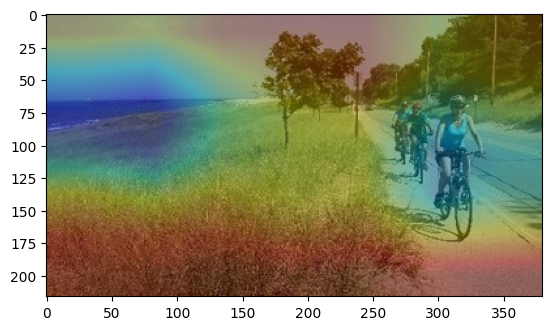

In [20]:
i = 4 #index of lakeside
CAM1 = returnCAM(logit_conv.squeeze(),idx[i])
plot_CAM(img_np,CAM1)

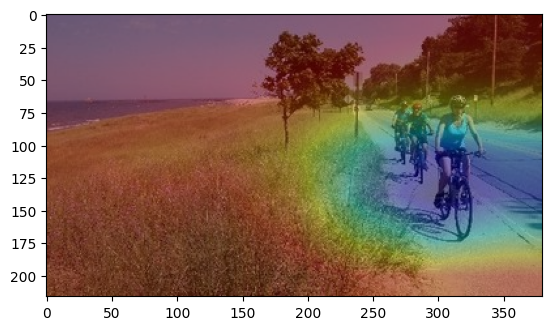

In [21]:
i = 0#index of mountain bike
CAM2 = returnCAM(logit_conv.squeeze(),idx[i])
plot_CAM(img_np,CAM2)

# 2- Adversarial examples

In this second part, we will look at [adversarial examples](https://arxiv.org/abs/1607.02533): "An adversarial example is a sample of input data which has been modified very slightly in a way that is intended to cause a machine learning classifier to misclassify it. In many cases, these modifications can be so subtle that a human observer does not even notice the modification at all, yet the classifier still makes a mistake. Adversarial examples pose security concerns because they could be used to perform an attack on machine learning systems..."

Rules of the game:
- the attacker cannot modify the classifier, i.e. the neural net with the preprocessing done on the image before being fed to the network. 
- even if the attacker cannot modifiy the classifier, we assume that the attacker knows the architecture of the classifier. Here, we will still work with `resnet18` and the standard Imagenet normalization. 
- the attacker can only modify the physical image fed into the network.
- the attacker should fool the classifier, i.e. the label obtained on the corrupted image should not be the same as the label predicted on the original image.

First, you will implement *Fast gradient sign method (FGSM)* wich is described in Section 2.1 of [Adversarial examples in the physical world](https://arxiv.org/abs/1607.02533). The idea is simple, suppose you have an image $\mathbf{x}$ and when you pass it through the network, you get the 'true' label $y$. You know that your network has been trained by minimizing the loss $J(\mathbf{\theta}, \mathbf{x}, y)$ with respect to the parameters of the network $\theta$. Now, $\theta$ is fixed as you cannot modify the classifier so you need to modify $\mathbf{x}$. In order to do so, you can compute the gradient of the loss with respect to $\mathbf{x}$ i.e. $\nabla_{\mathbf{x}} J(\mathbf{\theta}, \mathbf{x}, y)$ and use it as follows to get the modified image $\tilde{\mathbf{x}}$:
$$
\tilde{\mathbf{x}} = \text{Clamp}\left(\mathbf{x} + \epsilon *
\text{sign}(\nabla_{\mathbf{x}} J(\mathbf{\theta}, \mathbf{x}, y)),0,1\right),
$$
where $\text{Clamp}(\cdot, 0,1)$ ensures that $\tilde{\mathbf{x}}$ is a proper image.
Note that if instead of sign, you take the full gradient, you are now following the gradient i.e. increasing the loss $J(\mathbf{\theta}, \mathbf{x}, y)$ so that $y$ becomes less likely to be the predicited label.

## Validation:
1. Implement this attack. Make sure to display the corrupted image.

2. For what value of epsilon is your attack successful? What is the predicited class then?

<span style="color:red">**Answer:**</span>    
For $ϵ = 10^{-3}$, the class predicted is "Jeep". The result is still plausible since it's a type of car. However, for higher values of $\epsilon$, for instance, $5\times10^{-3}$, the prediction is "projectile", and the perturbed image we obtain has no remarkable difference from the original one.

3. plot the sign of the gradient and pass this image through the network. What prediction do you obtain? Compare to [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) 

<span style="color:red">**Answer:**</span>     
The result of my prediction has a probability of $0.58$ for the "honeycomb" class, and it is neither "minivan" nor "projectile". A similar phenomenon is noted in the paper where the presence of noise was identified as "nematode," which was not either of the original classes, "panda" or "gibbon."

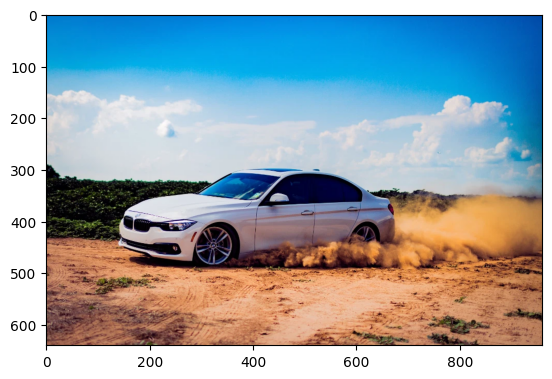

In [22]:
# Image under attack!
url_car = 'https://cdn130.picsart.com/263132982003202.jpg?type=webp&to=min&r=640'
response = requests.get(url_car)
img_pil = Image.open(io.BytesIO(response.content))
imshow(img_pil);

In [23]:
# same as above
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

for p in net.parameters():
    p.requires_grad = False
    
x = preprocess(img_pil).clone().unsqueeze(0)
logit = net(x)

In [24]:
_ = print_preds(logit)

0.639 -> ['n03770679', 'minivan']
0.065 -> ['n03594945', 'jeep']
0.039 -> ['n02814533', 'beach_wagon']
0.028 -> ['n02974003', 'car_wheel']
0.016 -> ['n03930630', 'pickup']


In [25]:
t_std = torch.from_numpy(np.array(n_std, dtype=np.float32)).view(-1, 1, 1)
t_mean = torch.from_numpy(np.array(n_mean, dtype=np.float32)).view(-1, 1, 1)

def plot_img_tensor(img):
    imshow(np.transpose(img.detach().numpy(), [1,2,0]))

def plot_untransform(x_t): 
    x_np = (x_t * t_std + t_mean).detach().numpy()
    x_np = np.transpose(x_np, [1, 2, 0])
    imshow(x_np)

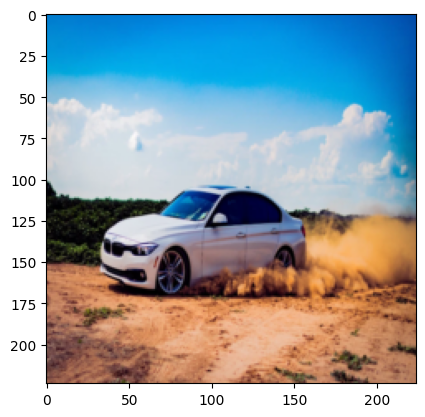

In [26]:
# here we display an image given as a tensor
x_img = (x * t_std + t_mean).squeeze(0)
plot_img_tensor(x_img)

In [27]:
# your implementation of the attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [28]:
idx = 656 #minivan
criterion = nn.CrossEntropyLoss()
x_img.requires_grad = True
logit = net(normalize(x_img).unsqueeze(0))
target = torch.tensor([idx])

    #TODO: compute the loss to backpropagate
net.eval()
net.zero_grad()
loss = criterion(logit, target)
loss.backward()
_ = print_preds(logit)

0.639 -> ['n03770679', 'minivan']
0.065 -> ['n03594945', 'jeep']
0.039 -> ['n02814533', 'beach_wagon']
0.028 -> ['n02974003', 'car_wheel']
0.016 -> ['n03930630', 'pickup']


In [29]:
# your attack here
epsilon = 5e-3
x_att = fgsm_attack(x_img,epsilon,x_img.grad)

In [30]:
# the new prediction for the corrupted image
logit = net(normalize(x_att).unsqueeze(0))
_ = print_preds(logit)

0.087 -> ['n04008634', 'projectile']
0.066 -> ['n02112018', 'Pomeranian']
0.047 -> ['n04037443', 'racer']
0.033 -> ['n03773504', 'missile']
0.027 -> ['n02112137', 'chow']


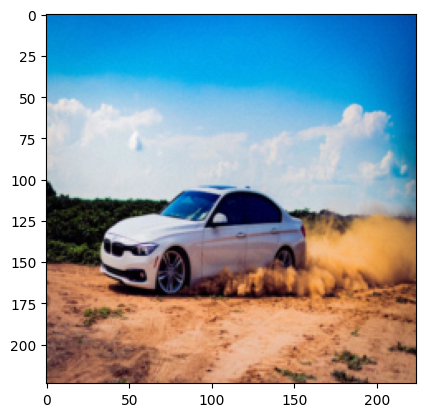

In [31]:
# can you see the difference?
plot_img_tensor(x_att)

> We can't see any differences. 

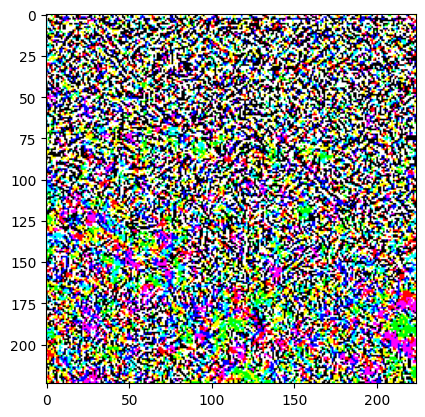

In [32]:
# do not forget to plot the sign of the gradient
gradient = x_img.grad.sign()
plot_img_tensor((1+gradient)/2)

In [33]:
# what is the prediction for the gradient? 
logit = net(normalize(gradient).unsqueeze(0))
_ = print_preds(logit)

0.580 -> ['n03530642', 'honeycomb']
0.322 -> ['n01930112', 'nematode']
0.087 -> ['n03759954', 'microphone']
0.003 -> ['n04332243', 'strainer']
0.002 -> ['n03729826', 'matchstick']


# 3- Transforming a car into a cat

We now implement the *Iterative Target Class Method (ITCM)* as defined by equation (4) in [Adversarial Attacks and Defences Competition](https://arxiv.org/abs/1804.00097)

To test it, we will transform the car (labeled minivan by our `resnet18`) into a [Tabby cat](https://en.wikipedia.org/wiki/Tabby_cat) (classe 281 in Imagenet). But you can try with any other target.

## Validation:
1. Implement the ITCM and make sure to display the resulting image. 

In [34]:
x = preprocess(img_pil).clone()
xd = preprocess(img_pil).clone()
xd.requires_grad = True

In [35]:
idx = 281 #tabby
optimizer = optim.SGD([xd], lr=0.01)
target = torch.tensor([idx])
for i in range(200):
    #TODO: your code here
    output = net(xd.unsqueeze(0))
    loss = criterion(output, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    xd.data = fgsm_attack(xd, -epsilon, xd.grad).data
    _ = print_preds(output)
    print(i,'-----------------')
    
    # TODO: break the loop once we are satisfied 
    if torch.argmax(output) == idx:
      break

0.639 -> ['n03770679', 'minivan']
0.065 -> ['n03594945', 'jeep']
0.039 -> ['n02814533', 'beach_wagon']
0.028 -> ['n02974003', 'car_wheel']
0.016 -> ['n03930630', 'pickup']
0 -----------------
0.172 -> ['n04037443', 'racer']
0.069 -> ['n03792972', 'mountain_tent']
0.060 -> ['n03770679', 'minivan']
0.056 -> ['n04552348', 'warplane']
0.055 -> ['n03100240', 'convertible']
1 -----------------
0.045 -> ['n03888257', 'parachute']
0.043 -> ['n04442312', 'toaster']
0.034 -> ['n03908714', 'pencil_sharpener']
0.032 -> ['n03598930', 'jigsaw_puzzle']
0.026 -> ['n03793489', 'mouse']
2 -----------------
0.142 -> ['n02112018', 'Pomeranian']
0.118 -> ['n02113023', 'Pembroke']
0.038 -> ['n02123597', 'Siamese_cat']
0.038 -> ['n02119022', 'red_fox']
0.023 -> ['n02114712', 'red_wolf']
3 -----------------
0.067 -> ['n03793489', 'mouse']
0.042 -> ['n04442312', 'toaster']
0.037 -> ['n03908714', 'pencil_sharpener']
0.036 -> ['n03598930', 'jigsaw_puzzle']
0.036 -> ['n04004767', 'printer']
4 -----------------
0.

In [36]:
_ = print_preds(output)

0.294 -> ['n02123045', 'tabby']
0.066 -> ['n03793489', 'mouse']
0.047 -> ['n04033995', 'quilt']
0.032 -> ['n02123159', 'tiger_cat']
0.032 -> ['n03598930', 'jigsaw_puzzle']


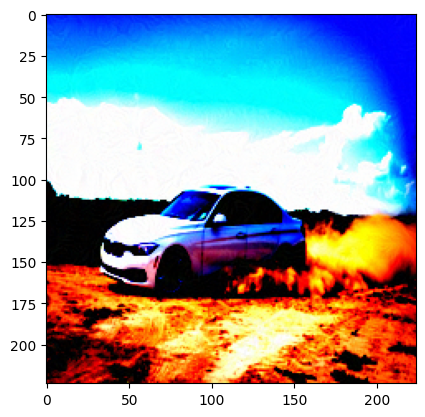

In [37]:
# plot the corrupted image
plot_img_tensor(xd)

# 4- Where is the cat hidden?

Last, we use CAM to understand where the network see a cat in the image.

## Validation:
1. display the CAM for the class tabby

2. display the CAM for the class minivan

3. where is the cat?

In [38]:
# converting image to np array
img_np = pil_2_np(img_pil)

# logit
logit_conv = net_conv(xd.unsqueeze(0))
logit_new = nn.AdaptiveAvgPool2d(output_size=(1,1))(logit_conv).reshape(-1, 1000)

# idx 
idx = print_preds(logit_new)


0.574 -> ['n02123045', 'tabby']
0.050 -> ['n02123597', 'Siamese_cat']
0.039 -> ['n02123394', 'Persian_cat']
0.036 -> ['n02113023', 'Pembroke']
0.034 -> ['n02123159', 'tiger_cat']


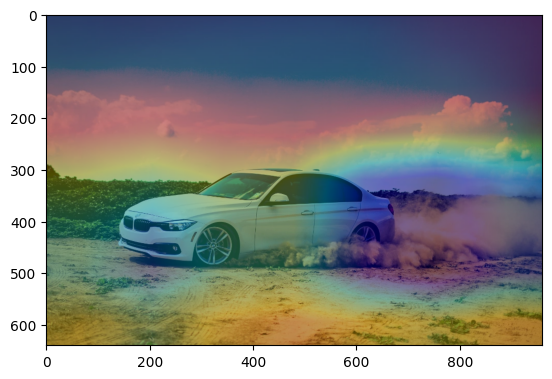

In [39]:
# CAM for tabby class
CAM1 = returnCAM(logit_conv.squeeze(),idx[0]) #tabby
plot_CAM(img_np, CAM1)

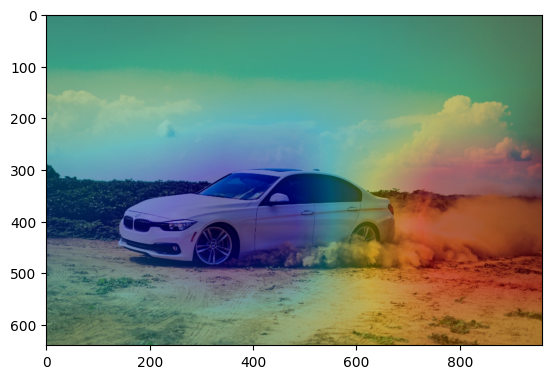

In [40]:
# CAM for minivan class
CAM2 = returnCAM(logit_conv.squeeze(),656) #minivan
plot_CAM(img_np, CAM2)

<span style="color:red">**Answer:**</span>       
The algorithm identifies the tabby cat amidst the smoke near behind the vehicle. 